In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32
EPOCHS = 50

# Load images from folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            images.append(img)
    return np.array(images)

# Load datasets
pre_disaster_images = load_images_from_folder('E:/Code/jupyter/disas/dataset/train/pre_disaster')
post_disaster_images = load_images_from_folder('E:/Code/jupyter/disas/dataset/train/post_disaster')

# Normalize images
pre_disaster_images = pre_disaster_images / 255.0
post_disaster_images = post_disaster_images / 255.0

# Create binary masks (assuming the post-disaster images are labeled)
y_train_binary = np.where(post_disaster_images.sum(axis=-1, keepdims=True) > 0, 1, 0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(pre_disaster_images, y_train_binary, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [13]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Assuming y_train and y_val contain your target images
y_train_binary = np.where(y_train.sum(axis=-1, keepdims=True) > 0, 1, 0)
y_val_binary = np.where(y_val.sum(axis=-1, keepdims=True) > 0, 1, 0)


In [14]:
history = model.fit(datagen.flow(X_train, y_train_binary, batch_size=BATCH_SIZE),
                    validation_data=(X_val, y_val_binary),
                    epochs=1,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_steps=len(X_val) // BATCH_SIZE)

# Make predictions
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

3/3 ━━━━━━━━━━━━━━━━━━━━ 163s 48s/step - accuracy: 0.4889 - loss: 0.6741 - val_accuracy: 0.9466 - val_loss: 0.5048
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def count_damaged_buildings(prediction):
    return np.sum(prediction)

# Function to highlight damage areas
def highlight_damage(original, prediction):
    highlighted_image = original.copy()
    # Create a color mask for highlighting
    mask = np.zeros_like(original)
    
    # Check if all pixels are predicted as damaged
    if np.all(prediction == 1):
        mask[:] = [255, 0, 0]  # Red for fully damaged image
    # Check if all pixels are predicted as undamaged    
    elif np.all(prediction == 0):
        mask[:] = [255, 255, 255]  # White for fully undamaged image
    else:
        mask[prediction == 1] = [255, 0, 0]  # Red for damaged areas
        mask[prediction == 0] = [255, 255, 255]  # White for undamaged areas
    
    # Combine original image with mask
    highlighted_image = cv2.addWeighted(highlighted_image, 0.7, mask, 0.3, 0)
    return highlighted_image



unique_values = np.unique(y_train_binary)
print("Unique values in target images:", unique_values)


Unique values in target images: [0 1]


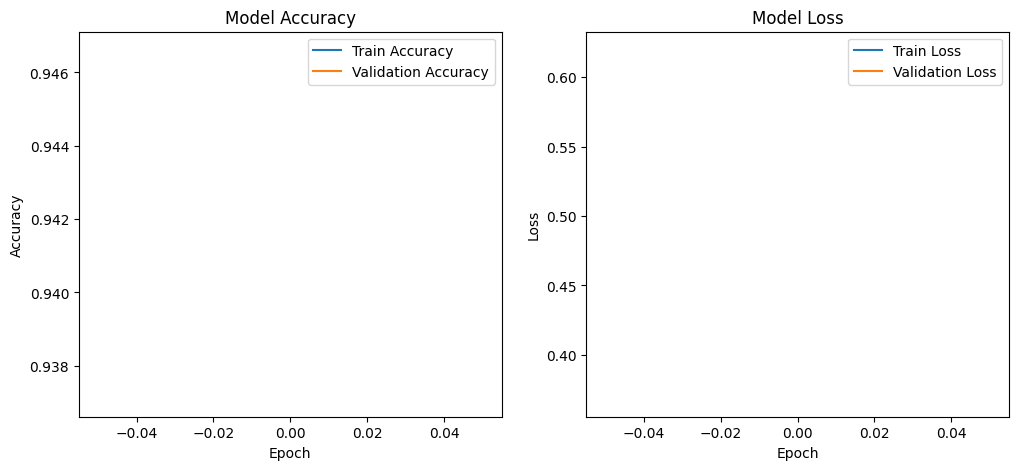

In [5]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 1

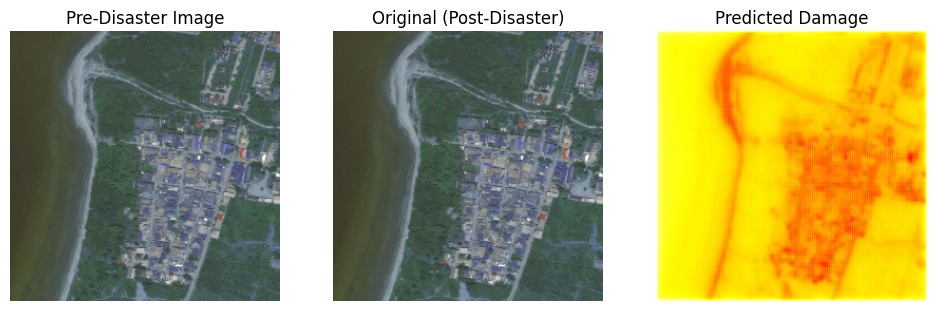

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sample_index = 3# Change this index to visualize different samples

cmap = colors.LinearSegmentedColormap.from_list('custom', ['white', 'yellow', 'orange', 'red'])
def display_results(pre_disaster, original, prediction, target):
    plt.figure(figsize=(16, 4))
    
    # Pre-disaster Image
    plt.subplot(1, 4, 1)
    plt.title('Pre-Disaster Image')
    plt.imshow(pre_disaster)
    plt.axis('off')  # Hide axes
    
    # Original Image (Post-Disaster)
    plt.subplot(1, 4, 2)
    plt.title('Original (Post-Disaster)')
    plt.imshow(original)
    plt.axis('off')  # Hide axes

    # Predicted Damage
    plt.subplot(1, 4, 3)
    plt.title('Predicted Damage')
    plt.imshow(prediction.squeeze(), cmap=custom_colormap)
    plt.axis('off')  # Hide axes

    # Highlighted Damage Areas
    highlighted_image = highlight_damage(original, prediction)
    plt.subplot(1, 4, 4)
    plt.title('Highlighted Damage')
    plt.imshow(highlighted_image)
    plt.axis('off')  # Hide axes

    plt.show()

# Example usage
display_results(X_val[sample_index], X_val[sample_index], y_pred[sample_index], y_pred[sample_index])

# Assuming y_val contains your target images




In [8]:
def count_damaged_buildings(prediction):
    damaged_area = np.sum(prediction)
    # Assuming each pixel corresponds to a building unit
    return damaged_area
sample_image_index=2
damaged_buildings_count = count_damaged_buildings(y_pred_binary[sample_image_index])
print(f"Number of Damaged Buildings: {damaged_buildings_count}")


Number of Damaged Buildings: 65536


In [9]:
def classify_disaster(damaged_count, total_count):
    damage_percentage = (damaged_count / total_count) * 100
    if damage_percentage > 50:
        return "High"
    elif damage_percentage > 20:
        return "Medium"
    else:
        return "Low"

total_buildings = X_val[sample_image_index].shape[0]  # Assuming total buildings are known
disaster_severity = classify_disaster(damaged_buildings_count, total_buildings)
print(f"Disaster Severity: {disaster_severity}")


Disaster Severity: High


In [10]:
model.save('disaster_damage_assessment_model.h5')

In [18]:
unique_values = np.unique(y_pred_binary)
print("Unique values in predicted mask:", unique_values)


Unique values in predicted mask: [1]
